In [1]:
import os
import argparse
import time
from contextlib import contextmanager
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import json
import torch
import torchvision
import sys
sys.path.append("../")
from methods_v2 import NMF_CONCEPTS
from data_preprocessing import get_train_dataset_cifar10, get_test_dataset_cifar10, get_train_dataset_cifar100, get_test_dataset_cifar100, get_train_dataset_ImageNet_1K, get_test_dataset_ImageNet_1K
from models import load_pretrained_weights_32


# # device
device = torch.device("cuda:0")
print("Using device:", device)


# models
def load_model(experiment="cifar10", load_mlp=False):
    
    # model trained on CIFAR10
    if experiment == "cifar10":
        model = load_pretrained_weights_32()

    # model trained on CIFAR10
    elif experiment == "cifar100":
        model = load_pretrained_weights_32(dataset='CIFAR-100', model_version='s0', num_classes=100)
    
    # model trained on ImageNet
    elif experiment == "imagenet":
        weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V1
        model = torchvision.models.resnet50(weights=weights).to(device)

    else:
        raise ValueError("`experiment` should be 'cifar10' or 'cifar100'.")
    
    model.to(device)
    model.eval()
    return model


# datasets
def load_datasets(experiment: str = "cifar100"):

    # CIFAR10 
    if experiment == "cifar10":
        # 1a- load in-distribution dataset: CIFAR-10
        ds_fit = get_train_dataset_cifar10()
        ds_in = get_test_dataset_cifar10()
        # ds_out_dict = {
        #     "cifar100": get_test_dataset_cifar100(),
        #     "svhn" : get_test_dataset_svhn(),
        #     "places365" : get_test_dataset_places365(),
        #     "texture" : get_test_dataset_texture(),
        #     "Tin": get_test_dataset_Tiny(),
        # }

     # CIFAR100
    elif experiment == "cifar100":
        # 1a- load in-distribution dataset: CIFAR-10
        ds_fit = get_train_dataset_cifar100()
        ds_in = get_test_dataset_cifar100()
        # ds_out_dict = {
        #     "cifar10": get_test_dataset_cifar10(),
        #     "svhn" : get_test_dataset_svhn(),
        #     "places365" : get_test_dataset_places365(),
        #     "texture" : get_test_dataset_texture(),
        #     "Tin": get_test_dataset_Tiny(),
        # }

    elif experiment == "imagenet":
        # 1a- load in-distribution dataset: CIFAR-10
        ds_fit = get_train_dataset_ImageNet_1K()
        ds_in = get_test_dataset_ImageNet_1K()
        # ds_out_dict = {
        #     # "inaturalist": get_test_dataset_inaturalist(),
        #     # "ninco" : get_test_dataset_NINCO(),
        #     "ssb_hard" : get_test_dataset_SSB_hard(),
        #     "texture" : get_test_dataset_texture(),
        #     # "places365": get_test_dataset_places365(),
        # }
    

    else:
        raise ValueError("`experiment` should be or 'cifar10' or cifar100")

    print("moving data to : ", device)
    for x, y in ds_fit:
        x.to(device)
        y.to(device)

    for x, y in ds_in:
        x.to(device)
        y.to(device)

    # for name, ds_out in ds_out_dict.items():
    #     for x, y in ds_out:
    #         x.to(device)
    #         y.to(device)
       
    return ds_fit, ds_in # ds_out_dict




2024-07-09 14:45:16.917790: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-09 14:45:18.402890: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using device: cuda:0


In [2]:

class NMFHyperparameterTuning:
    def __init__(self, data="cifar10"):
        """
        Args:
            n_components_options (List[int]): List of n_components values to evaluate.
        """
        self.data = data
        self.ds_fit, self.ds_in = load_datasets(data)
        self.model = load_model(data)
        if data == "cifar10":
            self.n_components_options = [2, 5, 8, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]
        elif data == "cifar100":
            self.n_components_options = [25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300]
        elif data == "imagenet":
            self.n_components_options = [100, 200, 300, 400, 500, 600, 700,  800, 900, 1000, 1100, 1200, 1300, 1400, 1500]
        self.fitting_time = {}
        self.scoring_time = {}
        self.results = []

    def evaluate_nmf(self):
        """Evaluates NMF decomposition on different number of components : 
        - for every n_components value in 'n_components_options' : 
            - Train NMF model on 'ds_train' dataset.
            - Compute reconstruction error on 'ds_train' dataset.
            - compute scores on 'ds_in' dataset.
            - Store results in 'results' attribute.
            - calculate the statistics of the scores (mean, std, min, max)
            - calculate the time for fitting, scoring

        
        """
        for n_components in self.n_components_options:
            self.detector = NMF_CONCEPTS(n_components=n_components)
            time_start = time.time()
            print("Evaluate Detector for n_components : {}".format(n_components))
            self.detector.fit(self.model, fit_dataset=self.ds_fit,  feature_layers_id=[-2])
            time_end = time.time()
            fitting_time = time_end - time_start
            time_start_scoring = time.time()
            self.scores_in, _ = self.detector.score(self.ds_in) 
            time_end_scoring = time.time()
            # calculate average time per image for scoring
            avg_scoring_time = (time_end_scoring - time_start_scoring) / len(self.ds_in) * 1000 # in ms
            # calculating the reconstruction error 
            # Compute the product UV
            UV = np.dot(self.detector.U, self.detector.V)

            # Calculate the reconstruction error
            error_frobenius = np.linalg.norm(self.detector.A_train - UV, 'fro')
            norm_a = np.linalg.norm(self.detector.A_train, 'fro')

            # Calculate the percentage error
            percentage_error = (error_frobenius / norm_a) * 100
            # calculate the statistics of the scores (mean, std, min, max)
            mean_score = np.mean(self.scores_in)
            std_score = np.std(self.scores_in)
            min_score = np.min(self.scores_in)
            max_score = np.max(self.scores_in)

            # store results
            self.results.append({
                "n_components": n_components,
                "reconstruction_error": percentage_error,
                "mean_score": mean_score,
                "std_score": std_score,
                "min_score": min_score,
                "max_score": max_score,
                "fitting_time": fitting_time,
                "avg_scoring_time_per_img": avg_scoring_time,
                "scores_in": self.scores_in.tolist() 
            })

        # save results to json file
        with open(f"results_concepts_{self.data}.json", 'w') as f:
            json.dump(self.results, f)


    def load_results(self):
        """
        Load results from a JSON file.

        Parameters:
        file_path (str): The path to the JSON file containing the results.

        Returns:
        list: A list of dictionaries containing the loaded results.
        """
        with open(f"results_concepts_{self.data}.json", 'r') as f:
            self.results = json.load(f)


    def plot_results(self):
        """Plots the results of the NMF evaluations."""
    # Plot histogram for each n_components on separate figures
        for i, result in enumerate(self.results):
            plt.figure(figsize=(6, 5))  # Adjust the figure size as needed
            sns.histplot(result['scores_in'], kde=True, color='skyblue')
            plt.axvline(result['mean_score'], color='r', linestyle='--', label=f"Mean: {result['mean_score']:.2f}")
            plt.axvline(result['mean_score'] + result['std_score'], color='g', linestyle='--', label=f"+1 Std: {result['mean_score'] + result['std_score']:.2f}")
            plt.axvline(result['mean_score'] - result['std_score'], color='g', linestyle='--', label=f"-1 Std: {result['mean_score'] - result['std_score']:.2f}")
            plt.axvline(result['min_score'], color='b', linestyle=':', label=f"Min: {result['min_score']:.2f}")
            plt.axvline(result['max_score'], color='b', linestyle=':', label=f"Max: {result['max_score']:.2f}")
            plt.title(f"Histogram of Scores for n_components={result['n_components']}")
            plt.xlabel('Scores')
            plt.ylabel('Frequency')
            plt.legend()
            plt.tight_layout()
            plt.show()

        # Plot combined boxplot for all components on a separate figure
        plt.figure(figsize=(10, 10))  # Adjust the figure size as needed
        scores_df = pd.DataFrame({
            f"{result['n_components']}": result['scores_in']
            for result in self.results
        })
        sns.boxplot(data=scores_df)
        plt.title('Combined Boxplot of Scores for All n_components')
        plt.xlabel('Number of Components')
        plt.ylabel('Scores')
        plt.tight_layout()
        plt.show()

        # plot the differences in mean, std scores for all n_components
        mean_scores = [result['mean_score'] for result in self.results]
        std_scores = [result['std_score'] for result in self.results]
        plt.figure(figsize=(10, 5))
        plt.plot(self.n_components_options, mean_scores, label='Mean Scores', marker='o')
        plt.plot(self.n_components_options, std_scores, label='Std Scores', marker='o')
        plt.title('Mean and Std Scores vs. Number of Components')
        plt.xlabel('Number of Components')
        plt.ylabel('Scores')
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Plot fitting time and scoring time
        fitting_times = [result['fitting_time'] for result in self.results]
        scoring_times = [result['avg_scoring_time_per_img'] for result in self.results]
        plt.figure(figsize=(10, 5))
        plt.plot(self.n_components_options, fitting_times, label='Fitting Time', marker='o')
        plt.title('Fitting Time vs. Number of Components')
        plt.xlabel('Number of Components')
        plt.ylabel('Time (s)')
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(10, 5))
        plt.plot(self.n_components_options, scoring_times, label='Scoring Time', marker='o')
        plt.title('Scoring Time vs. Number of Components')
        plt.xlabel('Number of Components')
        plt.ylabel('Time (ms)')
        plt.tight_layout()
        plt.show()

        # Plot reconstruction error
        reconstruction_errors = [result['reconstruction_error'] for result in self.results]
        plt.figure(figsize=(10, 5))
        plt.plot(self.n_components_options, reconstruction_errors, label='Reconstruction Error', marker='o')
        plt.title('Reconstruction Error vs. Number of Components')
        plt.xlabel('Number of Components')
        plt.ylabel('Error (%)')
        plt.tight_layout()
        plt.show()




In [3]:

class NMFHyperparameterTuning_Neighbors:
    def __init__(self, data="cifar10", n_neighbors_options=[5 , 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300]):
        """
        Args:
            n_neighbors_options (List[int]): List of n_neighbors values to evaluate.
        """
        self.data = data
        self.ds_fit, self.ds_in = load_datasets(data)
        self.model = load_model(data)
        self.n_neighbors_options = n_neighbors_options
        self.fitting_time = {}
        self.scoring_time = {}
        self.results = []

    def evaluate_nmf(self):
        """Evaluates NMF decomposition on different number of neighborss : 
        - for every n_neighbors value in 'n_neighbors_options' : 
            - Train NMF model on 'ds_train' dataset.
            - Compute reconstruction error on 'ds_train' dataset.
            - compute scores on 'ds_in' dataset.
            - Store results in 'results' attribute.
            - calculate the statistics of the scores (mean, std, min, max)
            - calculate the time for fitting, scoring

        
        """
        if self.data == "cifar10":
            n_components = 10
        elif self.data == "cifar100":
            n_components = 100
        else:
            n_components = 1000
        for n_neighbors in self.n_neighbors_options:
            self.detector = NMF_CONCEPTS(n_neighbors=n_neighbors, n_components=n_components)
            time_start = time.time()
            print("Evaluate Detector for n_neighbors : {}".format(n_neighbors))
            self.detector.fit(self.model, fit_dataset=self.ds_fit,  feature_layers_id=[-2])
            time_end = time.time()
            fitting_time = time_end - time_start
            time_start_scoring = time.time()
            self.scores_in, _ = self.detector.score(self.ds_in) 
            time_end_scoring = time.time()
            # calculate average time per image for scoring
            avg_scoring_time = (time_end_scoring - time_start_scoring) / len(self.ds_in) * 1000 # in ms
            # calculating the reconstruction error 
            # Compute the product UV
            UV = np.dot(self.detector.U, self.detector.V)

            # Calculate the reconstruction error
            error_frobenius = np.linalg.norm(self.detector.A_train - UV, 'fro')
            norm_a = np.linalg.norm(self.detector.A_train, 'fro')

            # Calculate the percentage error
            percentage_error = (error_frobenius / norm_a) * 100
            # calculate the statistics of the scores (mean, std, min, max)
            mean_score = np.mean(self.scores_in)
            std_score = np.std(self.scores_in)
            min_score = np.min(self.scores_in)
            max_score = np.max(self.scores_in)

            # store results
            self.results.append({
                "n_neighbors": n_neighbors,
                "reconstruction_error": percentage_error,
                "mean_score": mean_score,
                "std_score": std_score,
                "min_score": min_score,
                "max_score": max_score,
                "fitting_time": fitting_time,
                "avg_scoring_time_per_img": avg_scoring_time,
                "scores_in": self.scores_in.tolist() 
            })

        # save results to json file
        with open(f"results_neighbors_{self.data}.json", 'w') as f:
            json.dump(self.results, f)

    def load_results(self):
        """
        Load results from a JSON file.

        Parameters:
        file_path (str): The path to the JSON file containing the results.

        Returns:
        list: A list of dictionaries containing the loaded results.
        """
        with open(f"results_neighbors_{self.data}.json", 'r') as f:
            self.results = json.load(f)

    def plot_results(self):
        """Plots the results of the NMF evaluations."""
    # Plot histogram for each n_neighbors on separate figures
        for i, result in enumerate(self.results):
            plt.figure(figsize=(6, 5))  # Adjust the figure size as needed
            sns.histplot(result['scores_in'], kde=True, color='skyblue')
            plt.axvline(result['mean_score'], color='r', linestyle='--', label=f"Mean: {result['mean_score']:.2f}")
            plt.axvline(result['mean_score'] + result['std_score'], color='g', linestyle='--', label=f"+1 Std: {result['mean_score'] + result['std_score']:.2f}")
            plt.axvline(result['mean_score'] - result['std_score'], color='g', linestyle='--', label=f"-1 Std: {result['mean_score'] - result['std_score']:.2f}")
            plt.axvline(result['min_score'], color='b', linestyle=':', label=f"Min: {result['min_score']:.2f}")
            plt.axvline(result['max_score'], color='b', linestyle=':', label=f"Max: {result['max_score']:.2f}")
            plt.title(f"Histogram of Scores for n_neighbors={result['n_neighbors']}")
            plt.xlabel('Scores')
            plt.ylabel('Frequency')
            plt.legend()
            plt.tight_layout()
            plt.show()

        # Plot combined boxplot for all neighbors on a separate figure
        plt.figure(figsize=(10, 10))  # Adjust the figure size as needed
        scores_df = pd.DataFrame({
            f"{result['n_neighbors']}": result['scores_in']
            for result in self.results
        })
        sns.boxplot(data=scores_df)
        plt.title('Combined Boxplot of Scores for All n_neighbors')
        plt.xlabel('Number of neighbors')
        plt.ylabel('Scores')
        plt.tight_layout()
        plt.show()

        # plot the differences in mean, std scores for all n_neighbors
        mean_scores = [result['mean_score'] for result in self.results]
        std_scores = [result['std_score'] for result in self.results]
        plt.figure(figsize=(10, 5))
        plt.plot(self.n_neighbors_options, mean_scores, label='Mean Scores', marker='o')
        plt.plot(self.n_neighbors_options, std_scores, label='Std Scores', marker='o')
        plt.title('Mean and Std Scores vs. Number of neighbors')
        plt.xlabel('Number of neighbors')
        plt.ylabel('Scores')
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Plot fitting time and scoring time
        fitting_times = [result['fitting_time'] for result in self.results]
        scoring_times = [result['avg_scoring_time_per_img'] for result in self.results]
        plt.figure(figsize=(10, 5))
        plt.plot(self.n_neighbors_options, fitting_times, label='Fitting Time', marker='o')
        plt.title('Fitting Time vs. Number of neighbors')
        plt.xlabel('Number of neighbors')
        plt.ylabel('Time (s)')
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(10, 5))
        plt.plot(self.n_neighbors_options, scoring_times, label='Scoring Time', marker='o')
        plt.title('Scoring Time vs. Number of neighbors')
        plt.xlabel('Number of neighbors')
        plt.ylabel('Time (ms)')
        plt.tight_layout()
        plt.show()

        # Plot reconstruction error
        reconstruction_errors = [result['reconstruction_error'] for result in self.results]
        plt.figure(figsize=(10, 5))
        plt.plot(self.n_neighbors_options, reconstruction_errors, label='Reconstruction Error', marker='o')
        plt.title('Reconstruction Error vs. Number of neighbors')
        plt.xlabel('Number of neighbors')
        plt.ylabel('Error (%)')
        plt.tight_layout()
        plt.show()




# Usage
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# ds_in = DataLoader(your_dataset, batch_size=64, shuffle=True)



the length of the CIFAR-10 Training dataset :  50000
the length of the CIFAR-10 Test dataset :  10000
moving data to :  cuda:0


checkpoint_path :  ../../models/CIFAR-10/cifar10_resnet18_32x32_base_e100_lr0.1_default/s0/best.ckpt
Model pretrained weight have been successfully loaded !


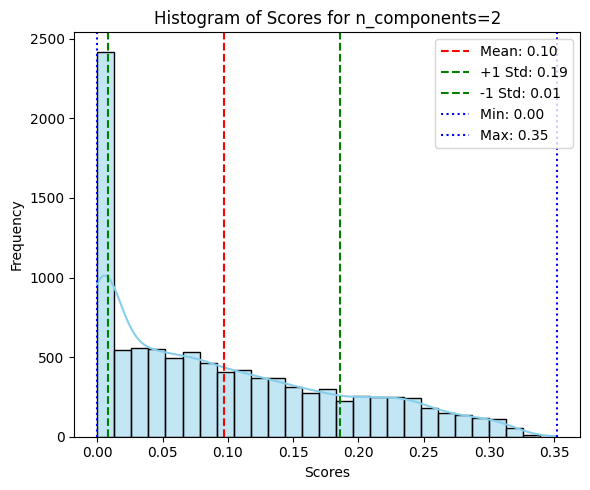

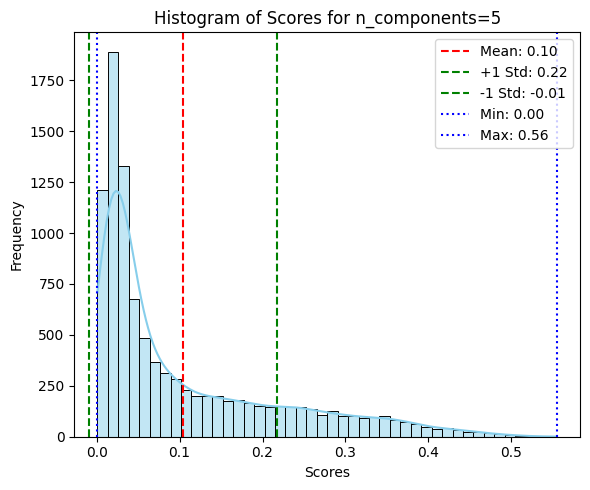

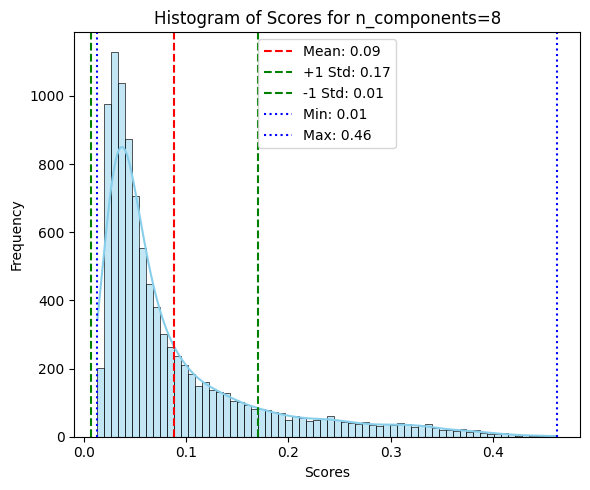

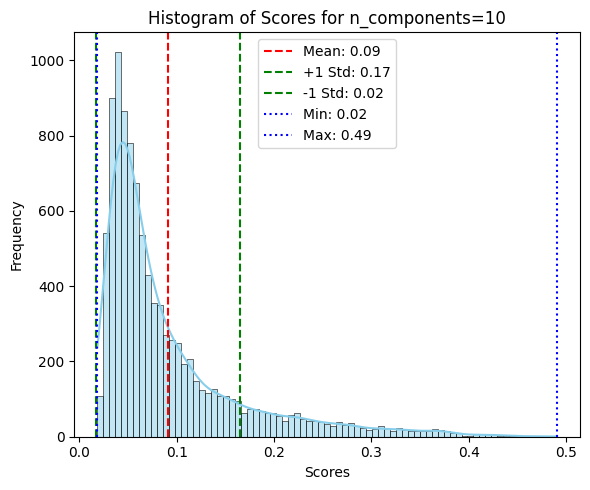

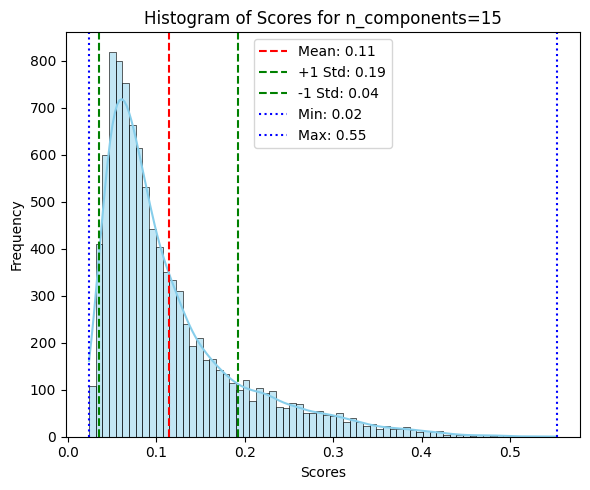

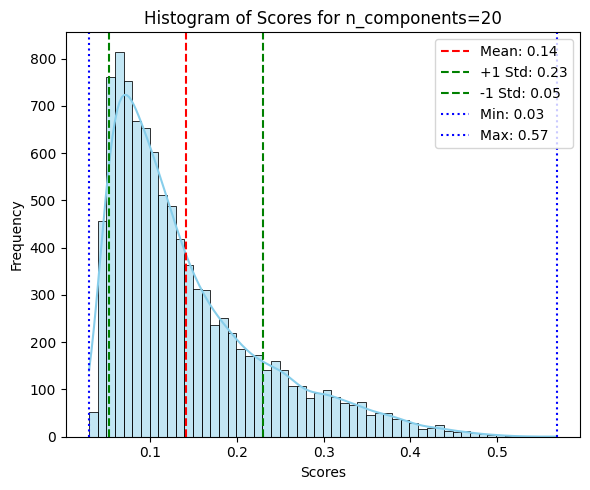

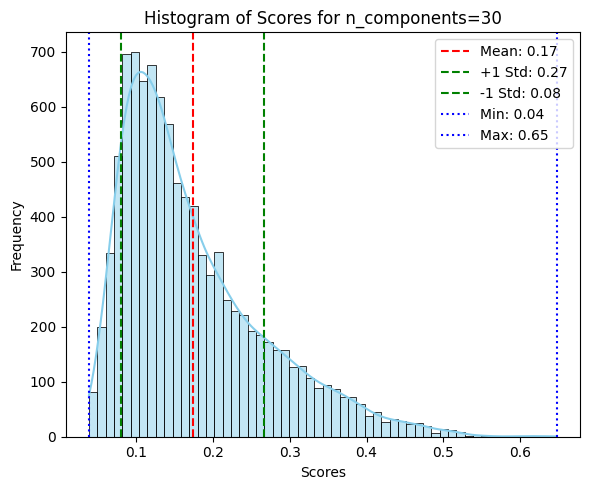

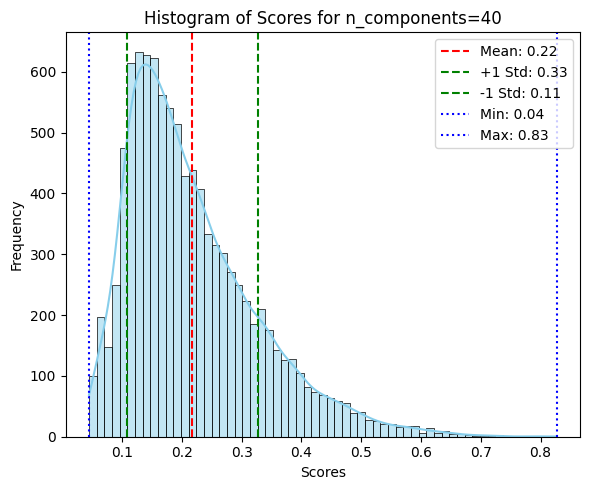

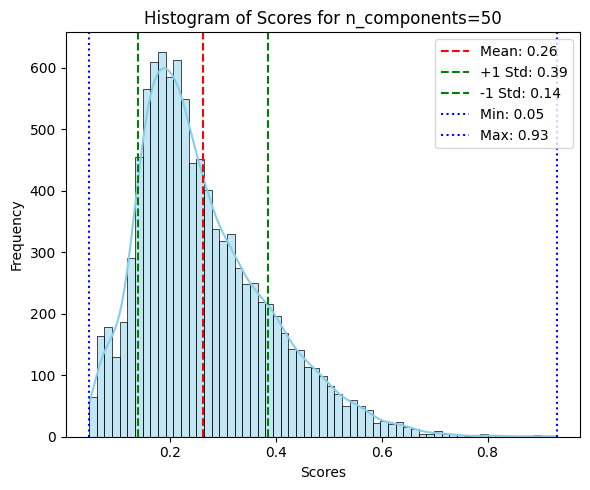

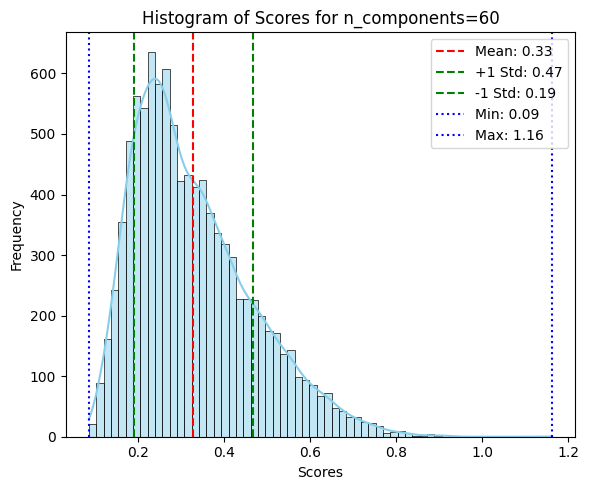

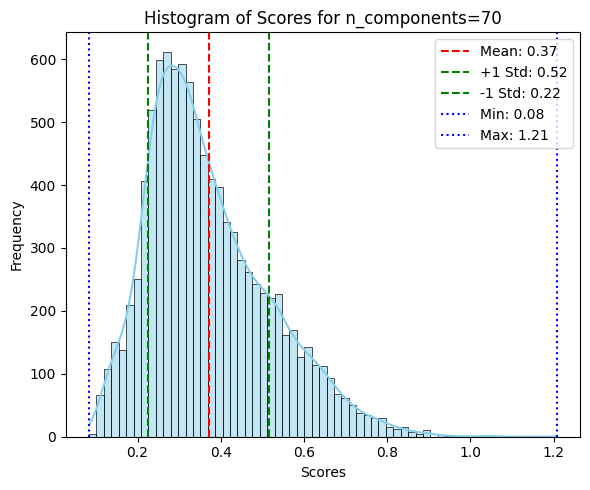

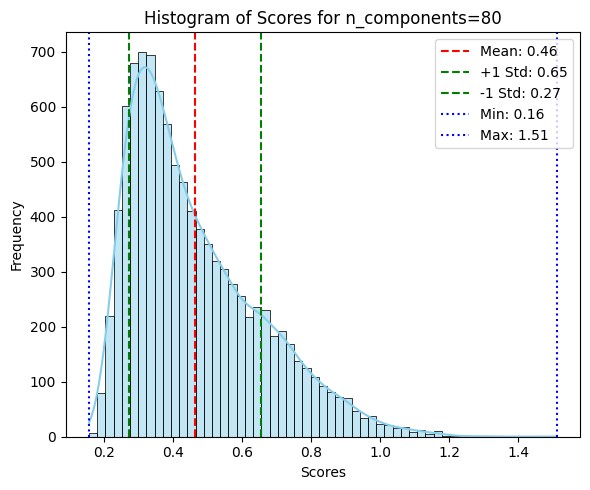

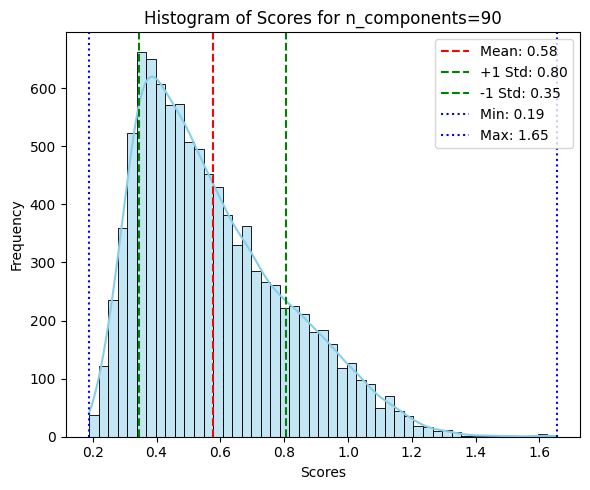

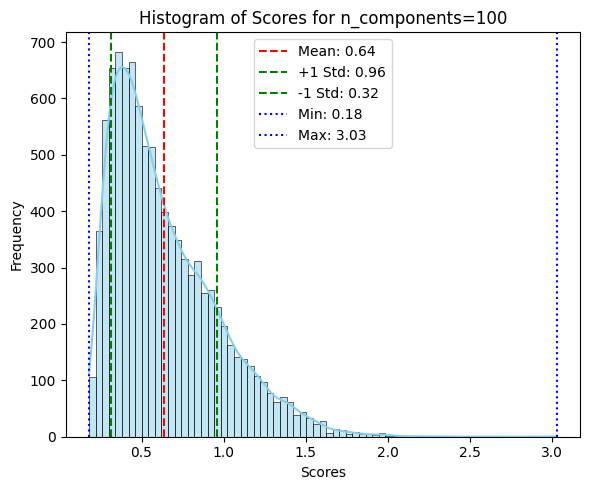

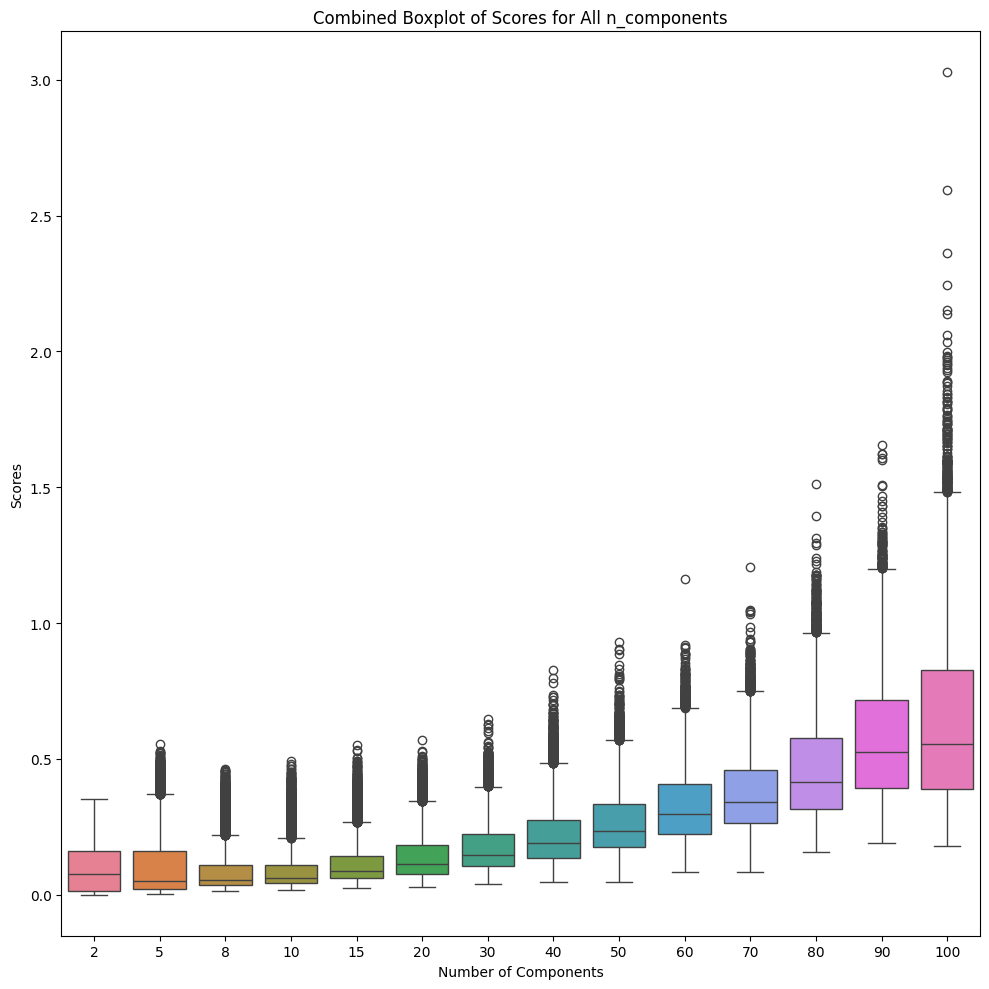

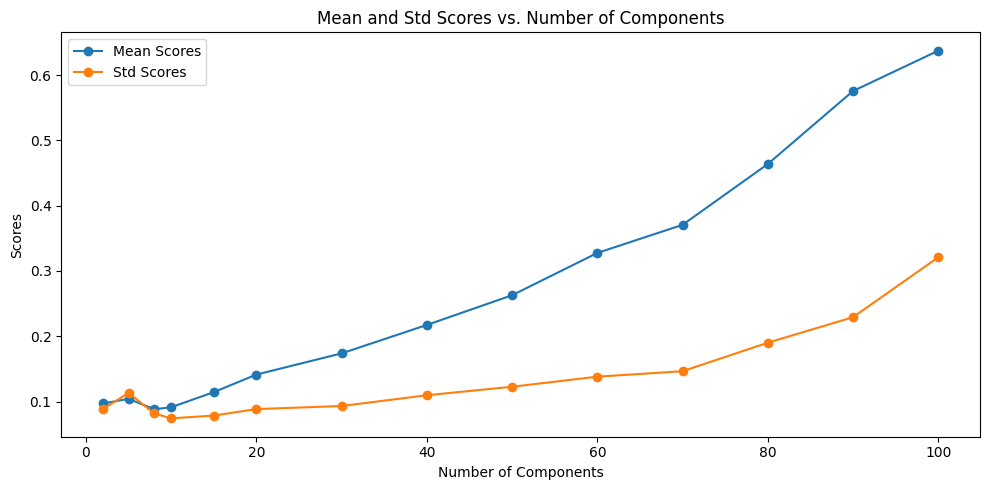

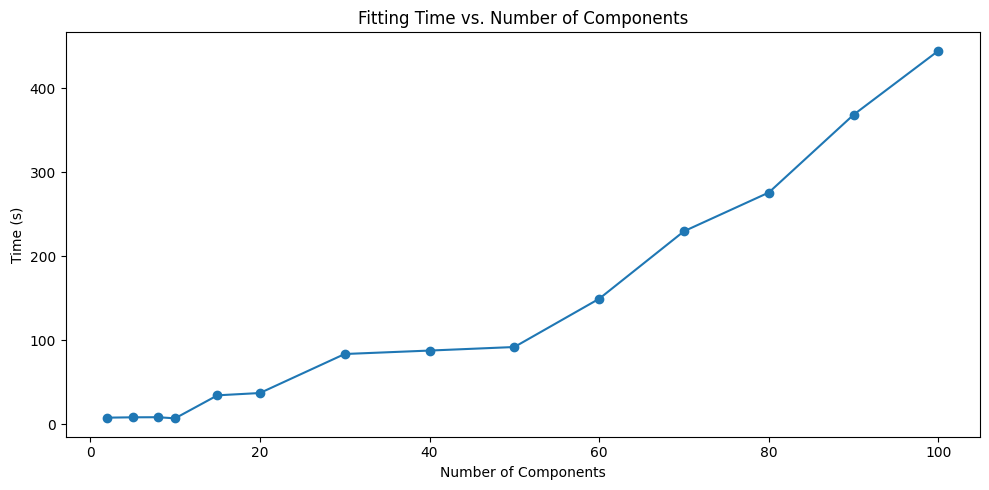

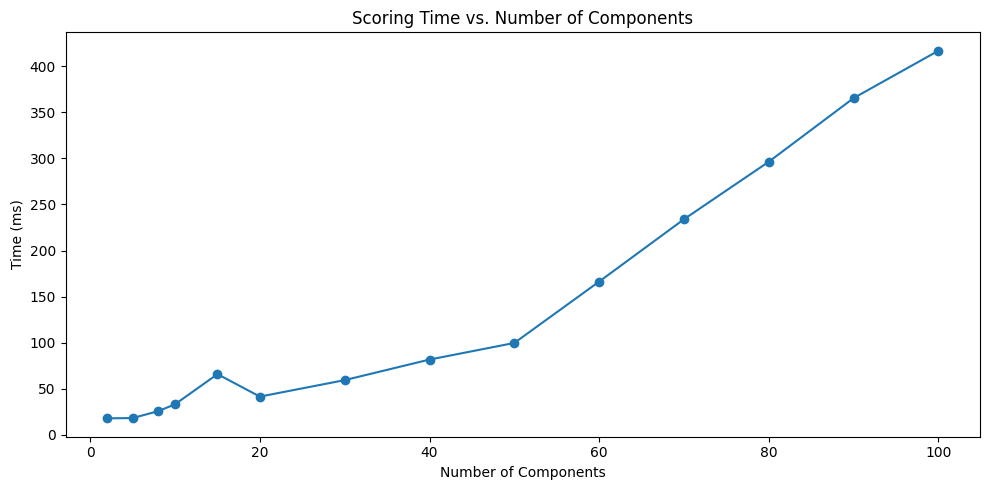

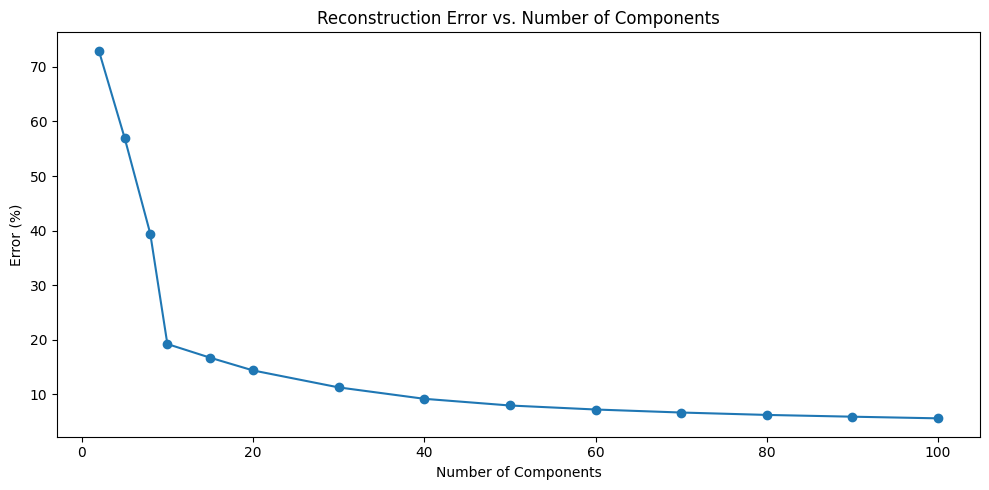

In [4]:

nmf_tuner = NMFHyperparameterTuning(data="cifar10")
# nmf_tuner.evaluate_nmf()
nmf_tuner.load_results()
nmf_tuner.plot_results()


the length of the CIFARO-100 Training dataset :  50000
the length of the CIFAR-100 Test dataset :  10000
moving data to :  cuda:0
checkpoint_path :  ../../models/CIFAR-100/cifar100_resnet18_32x32_base_e100_lr0.1_default/s0/best.ckpt
Model pretrained weight have been successfully loaded !


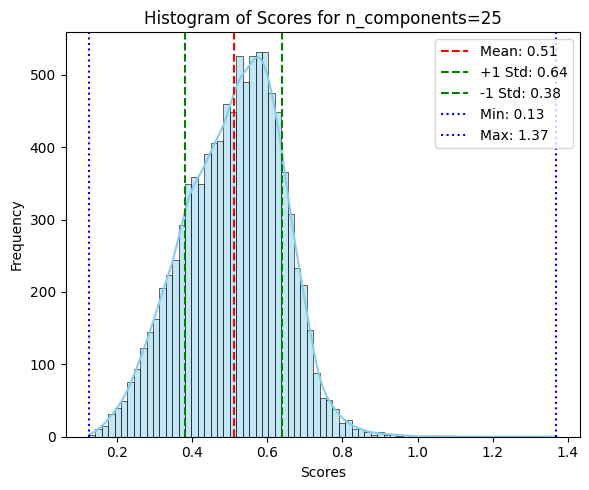

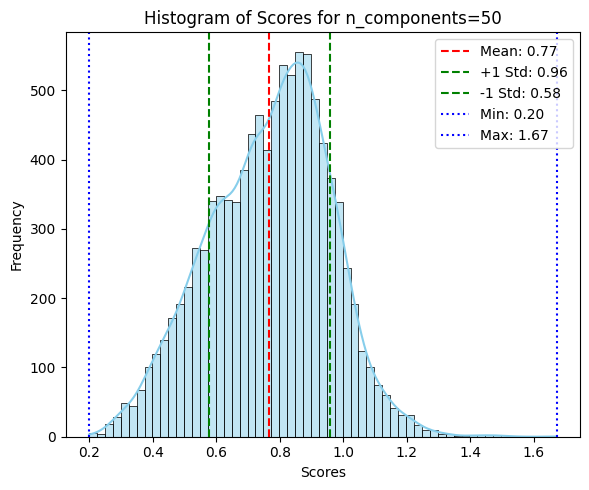

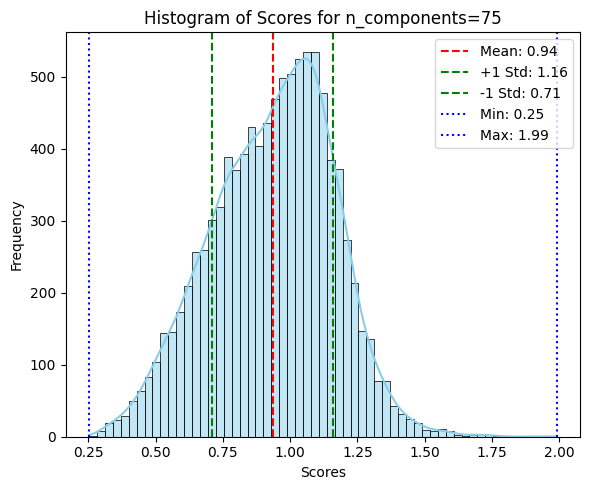

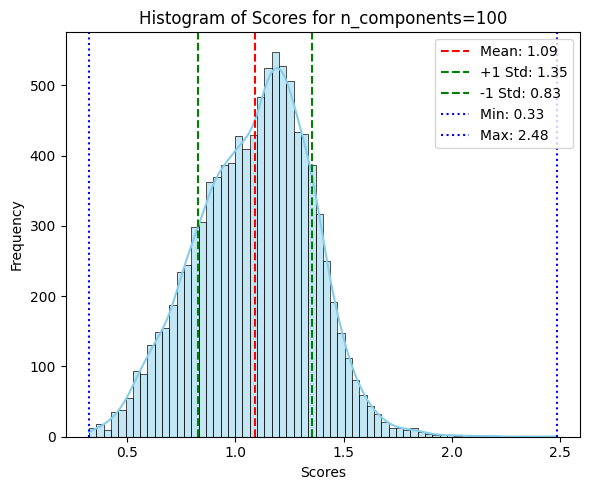

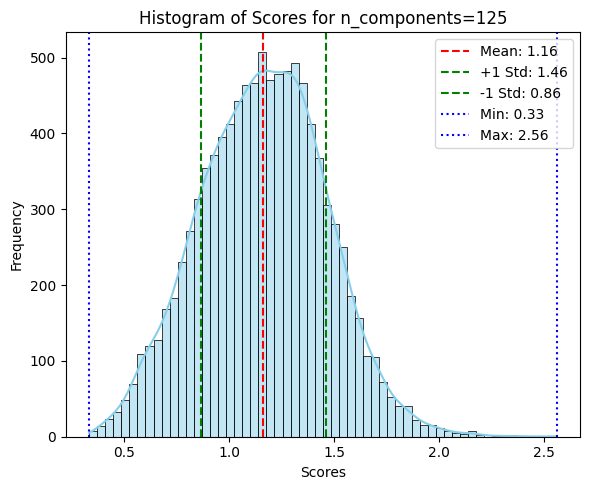

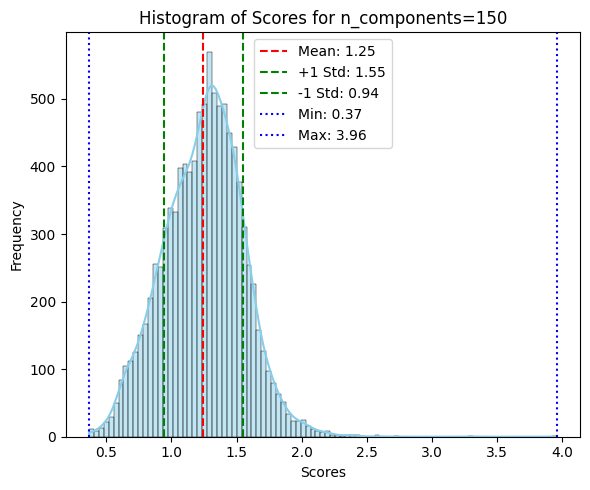

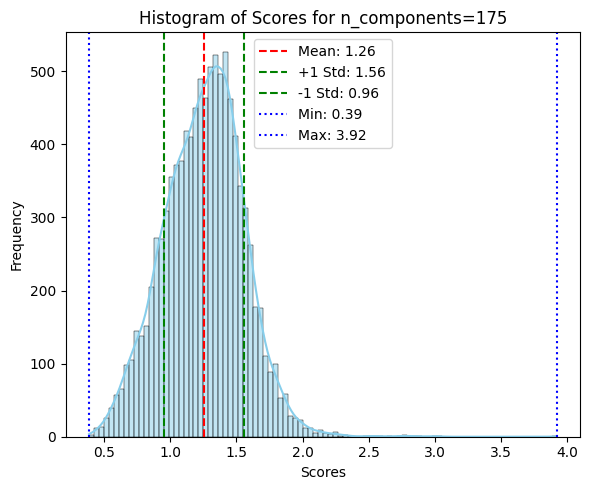

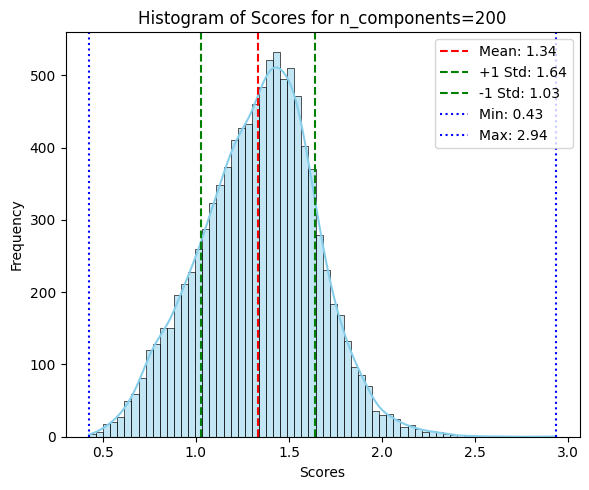

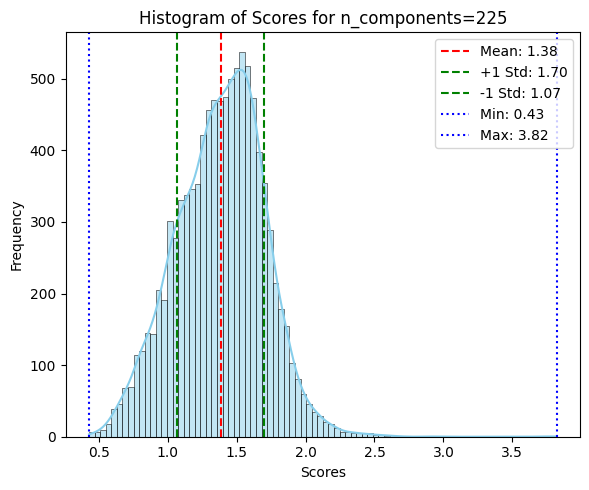

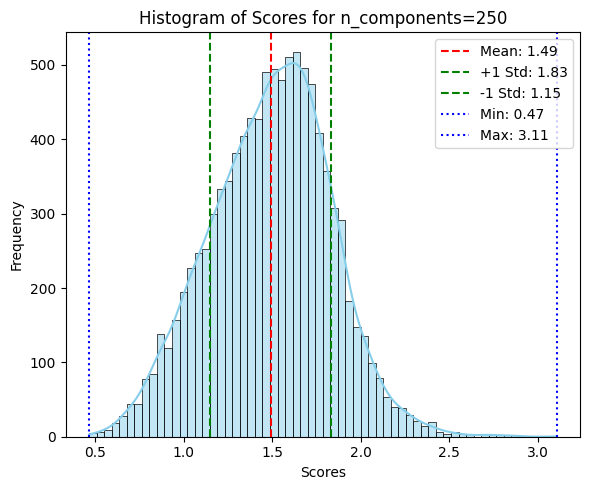

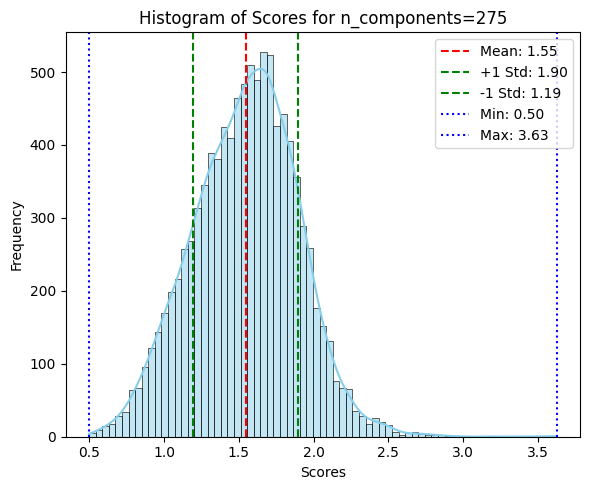

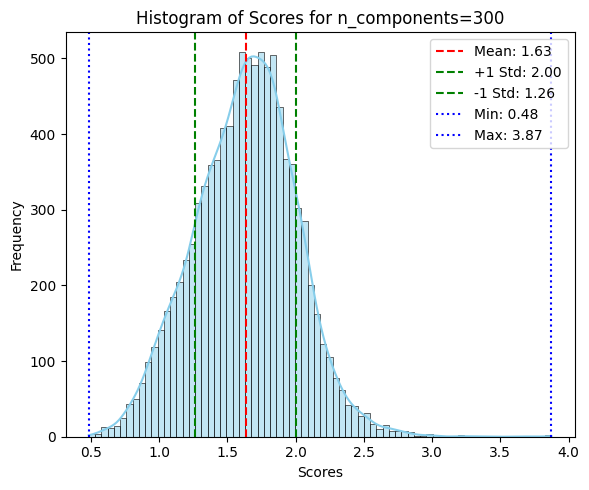

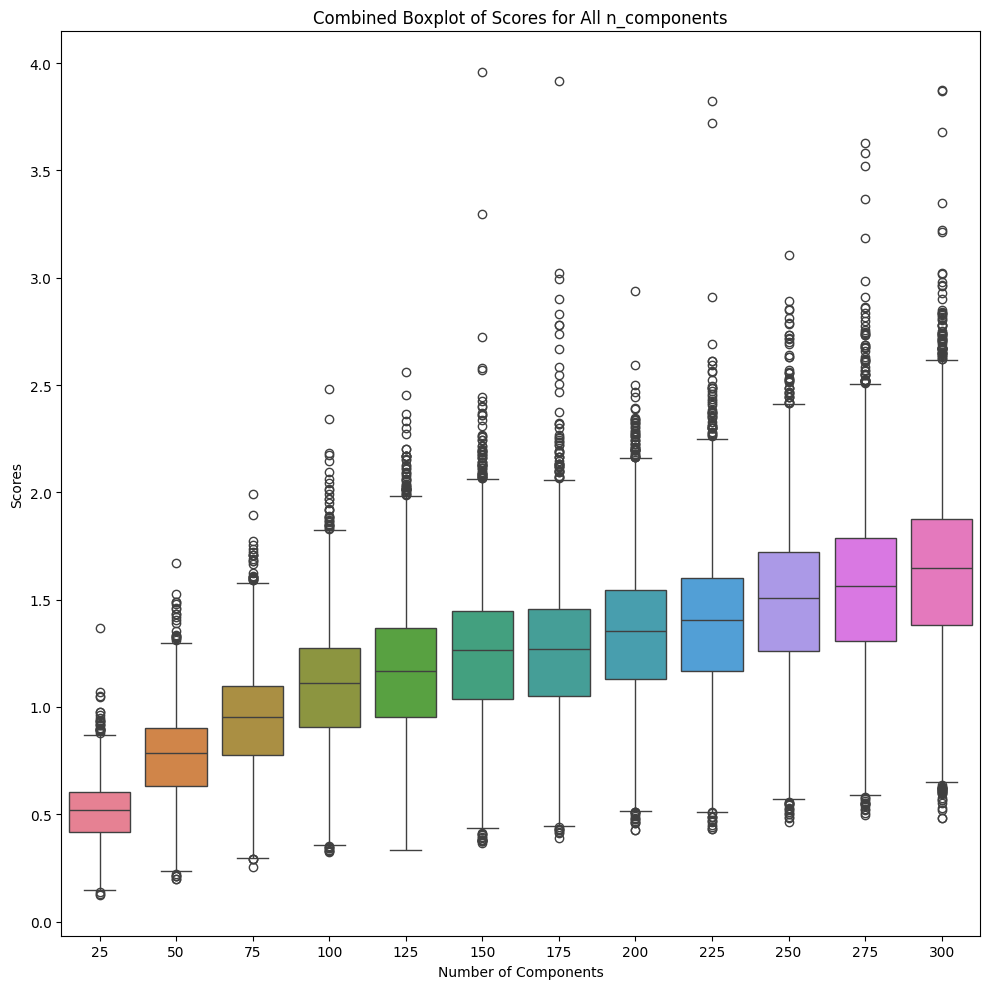

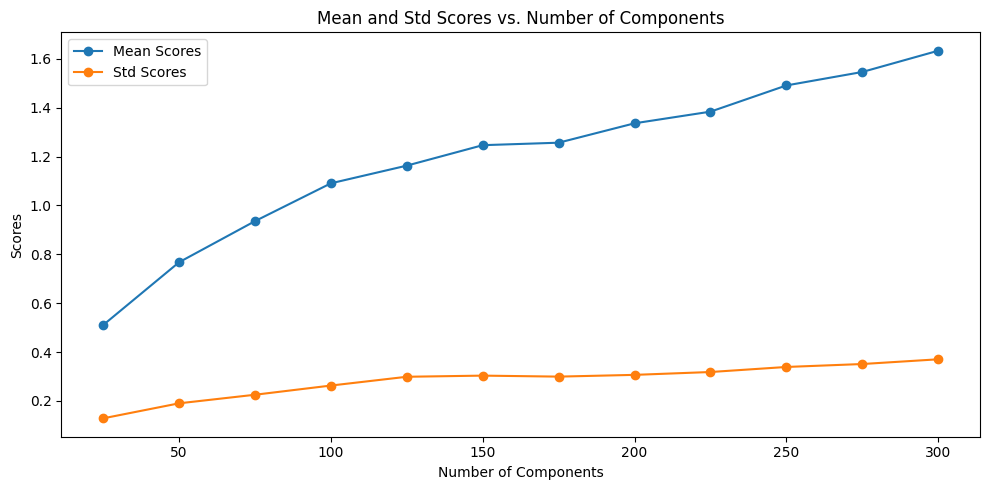

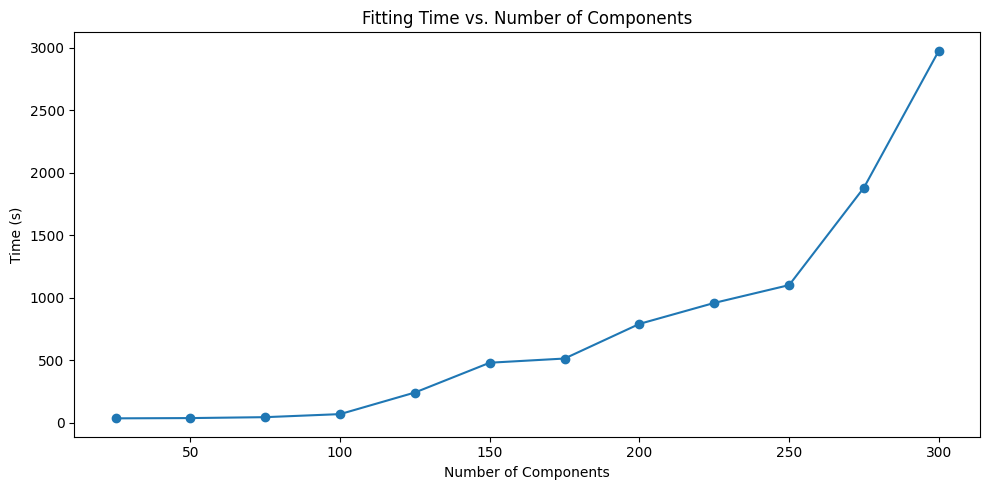

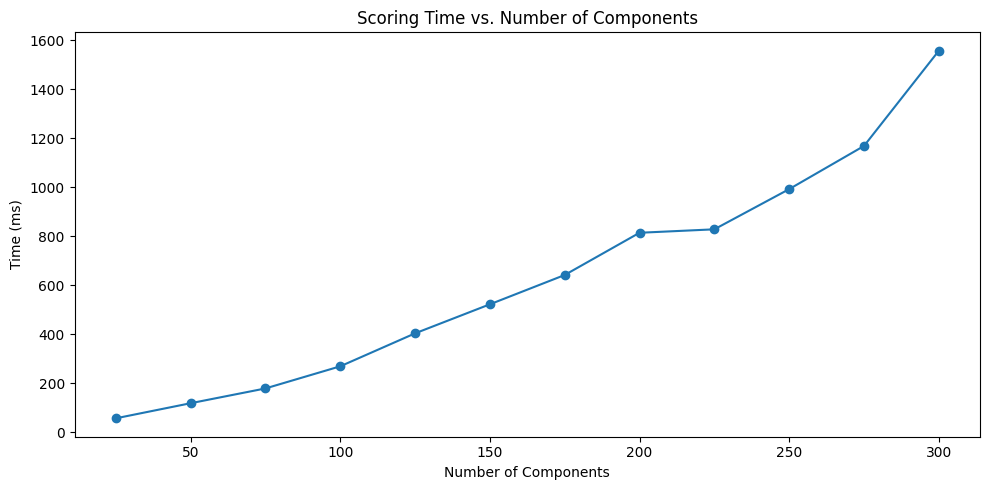

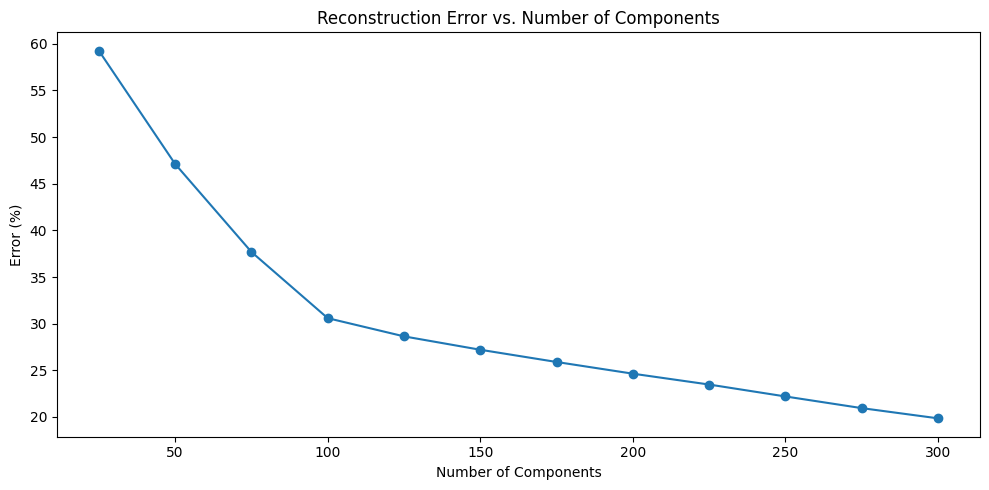

In [5]:
nmf_tuner_100 = NMFHyperparameterTuning(data="cifar100")
# nmf_tuner_100.evaluate_nmf()
nmf_tuner_100.load_results()
nmf_tuner_100.plot_results()

In [ ]:
# nmf_tuner_1000 = NMFHyperparameterTuning(data="imagenet")
# nmf_tuner_1000.evaluate_nmf()
# nmf_tuner_1000.plot_results()

the length of the CIFAR-10 Training dataset :  50000
the length of the CIFAR-10 Test dataset :  10000
moving data to :  cuda:0
checkpoint_path :  ../../models/CIFAR-10/cifar10_resnet18_32x32_base_e100_lr0.1_default/s0/best.ckpt
Model pretrained weight have been successfully loaded !


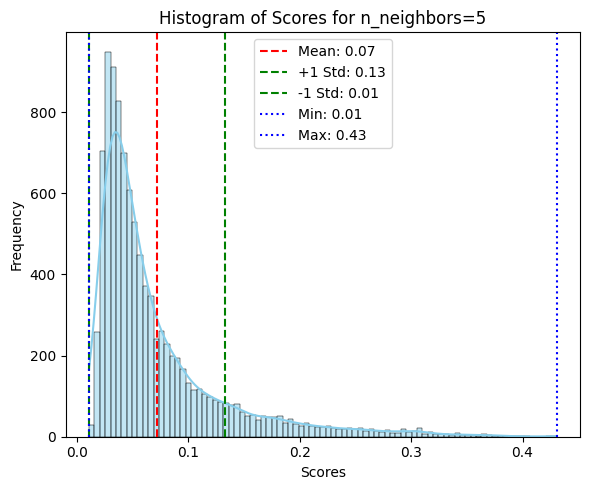

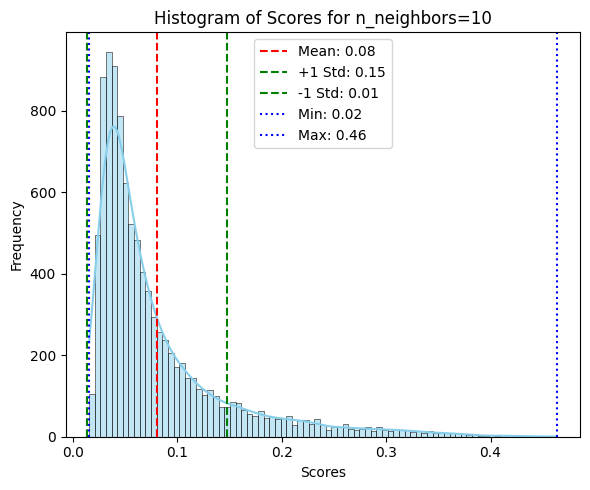

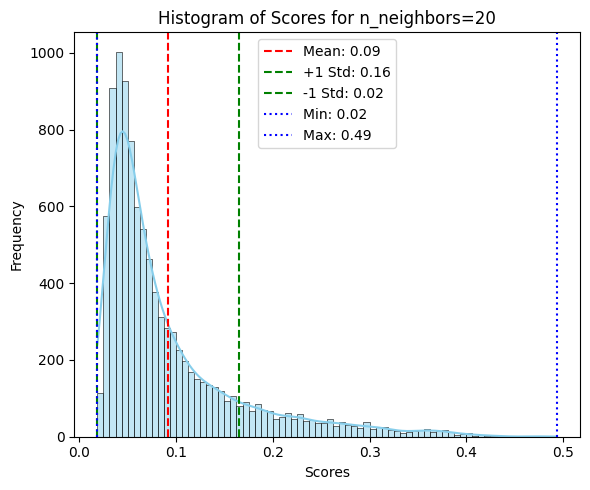

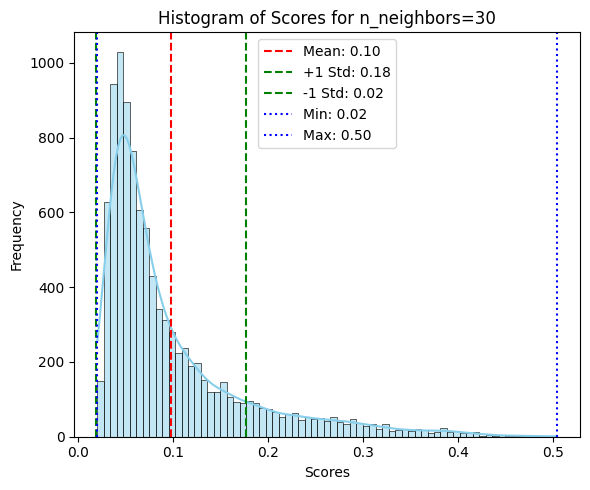

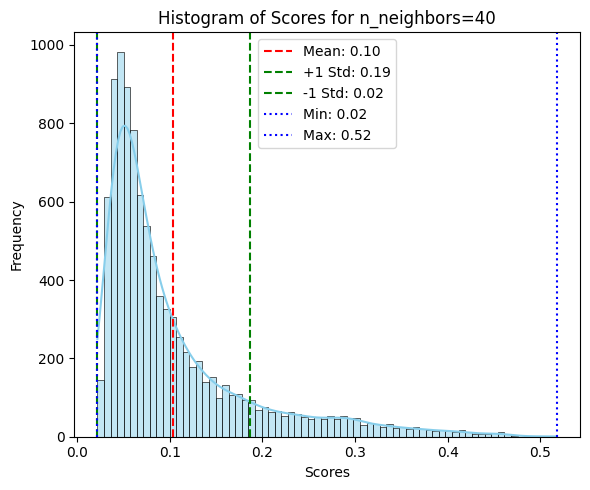

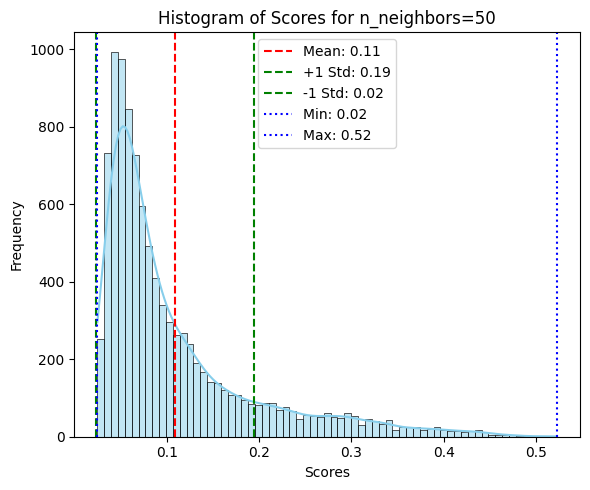

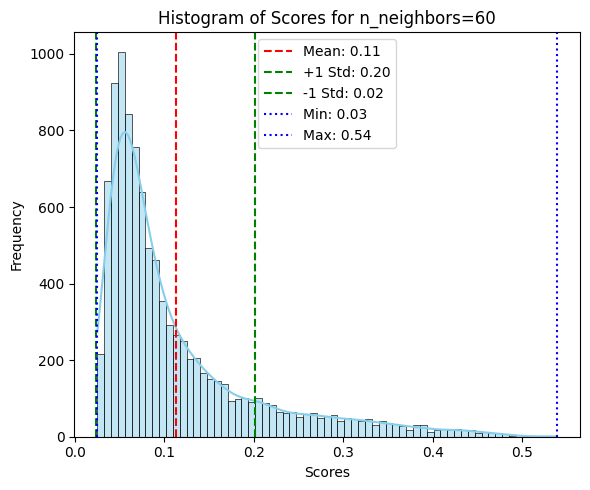

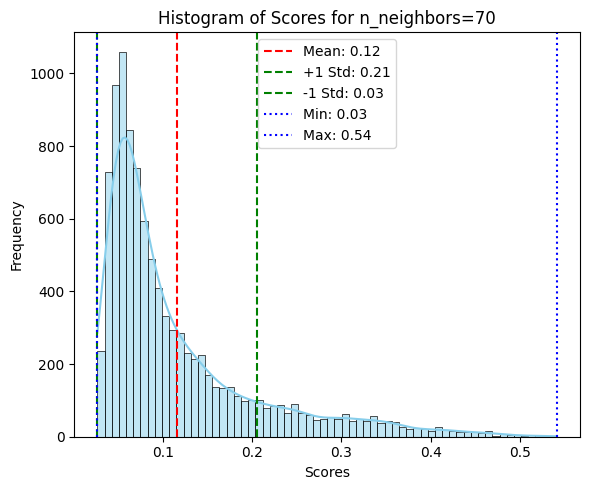

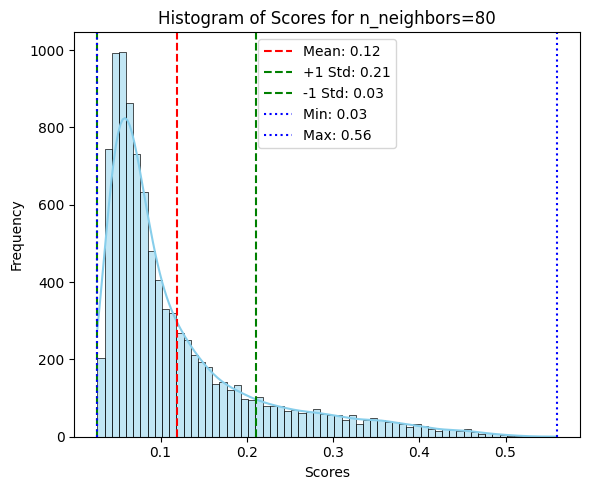

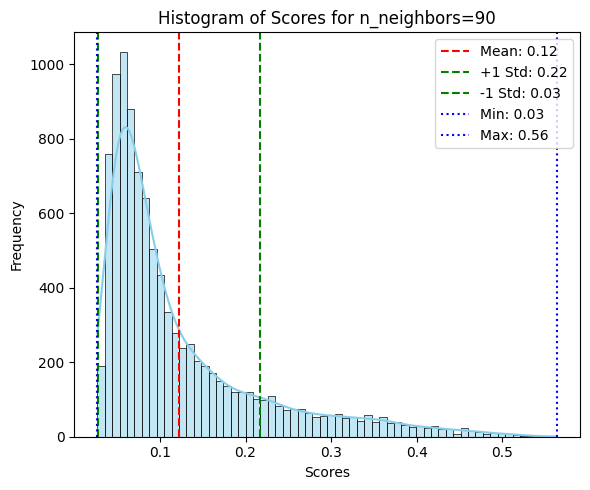

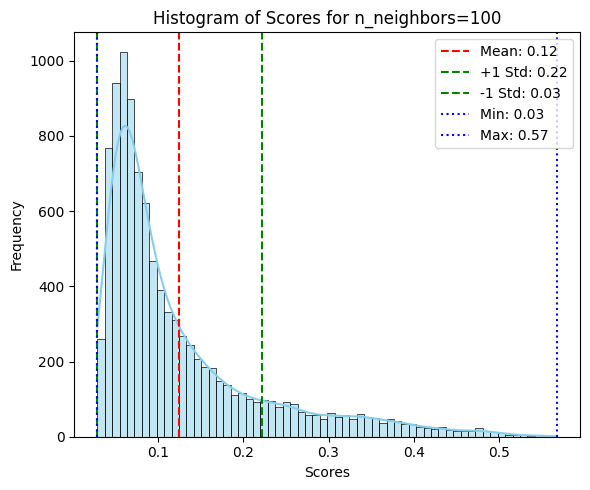

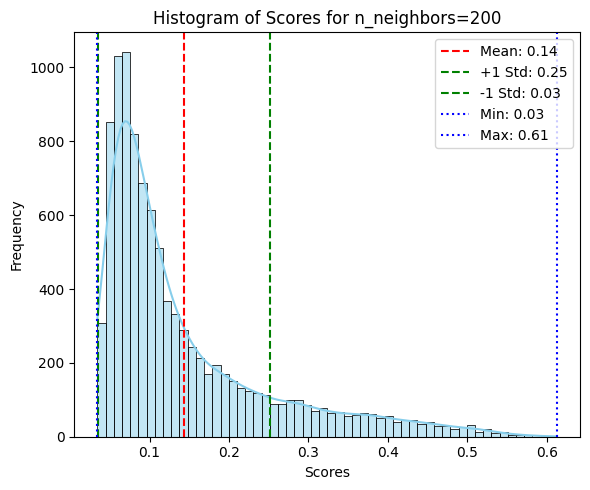

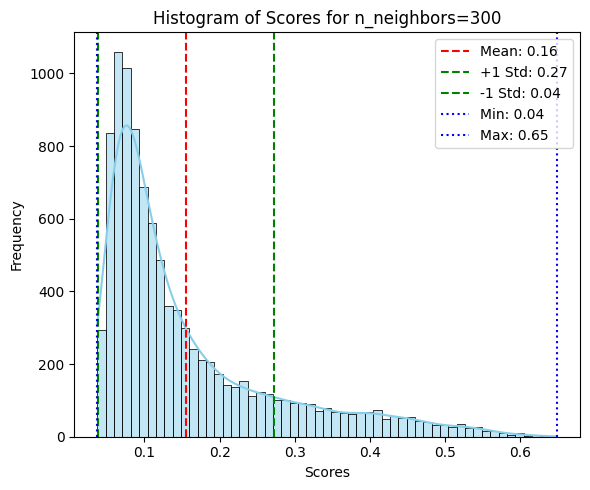

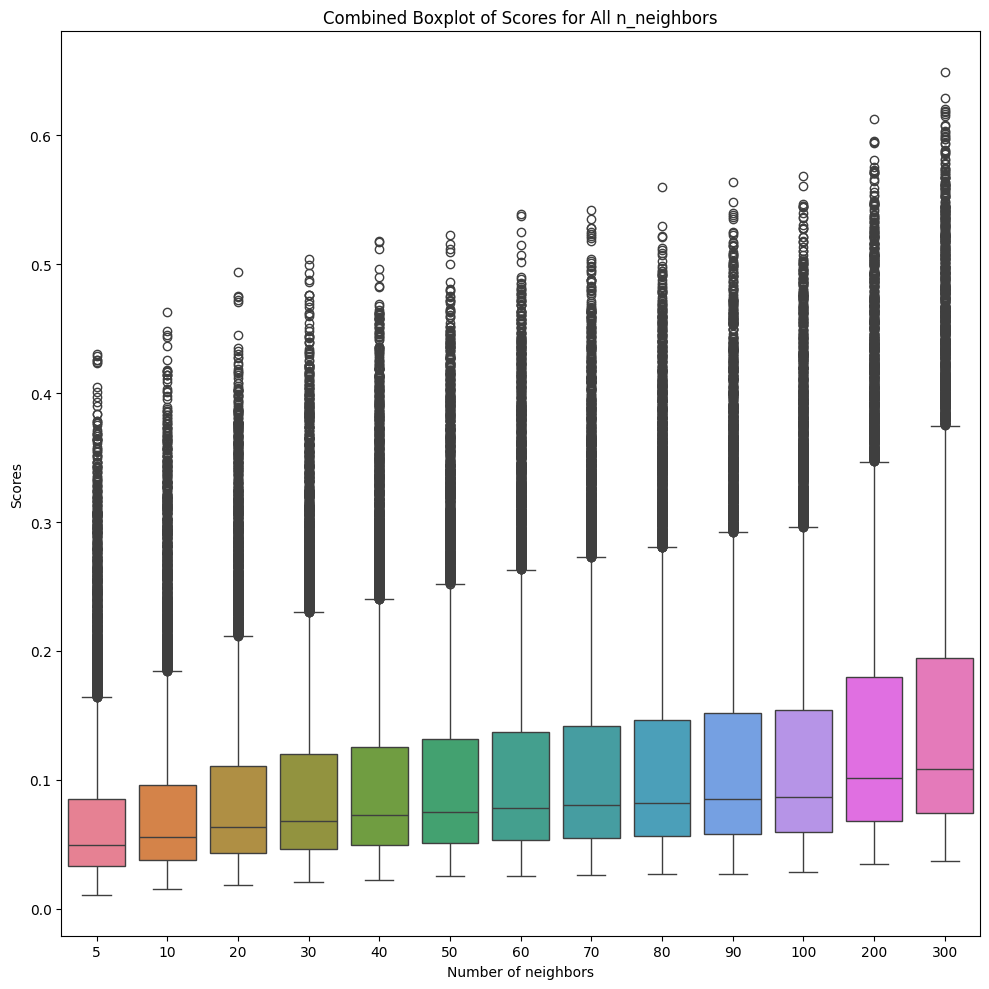

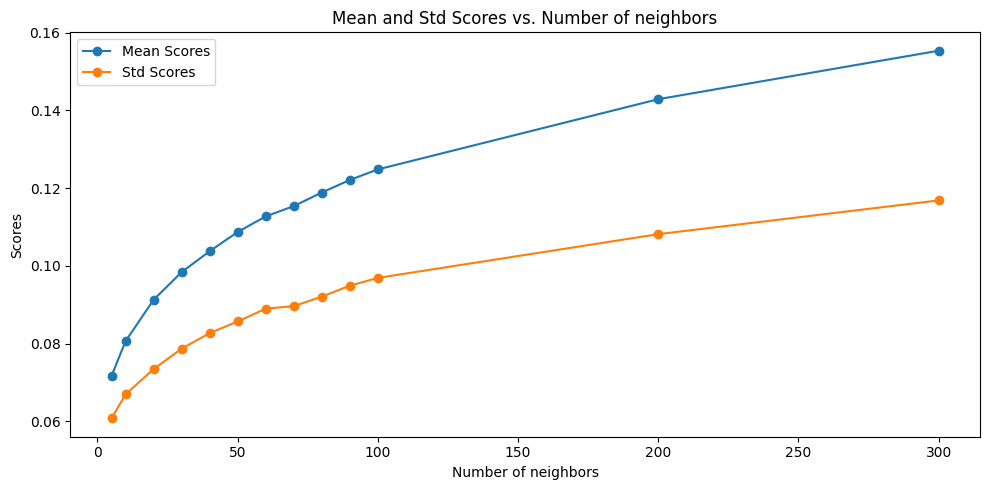

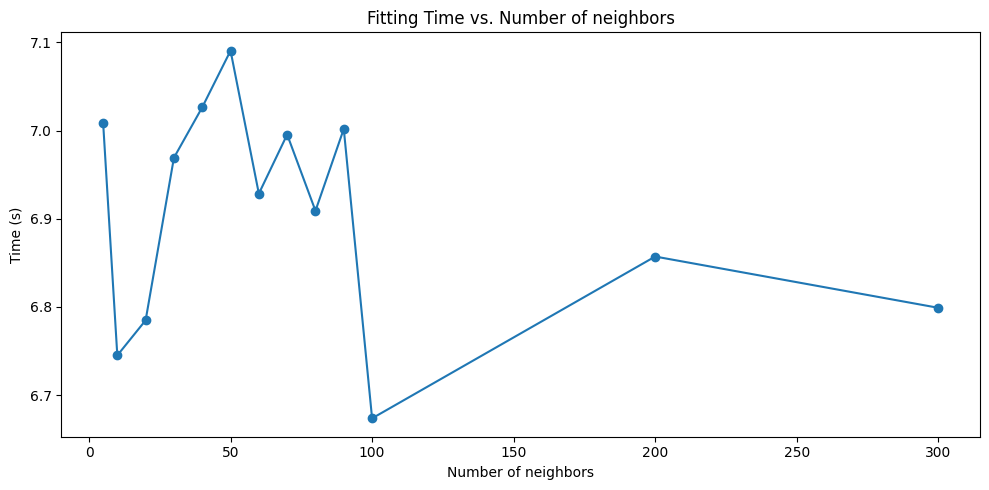

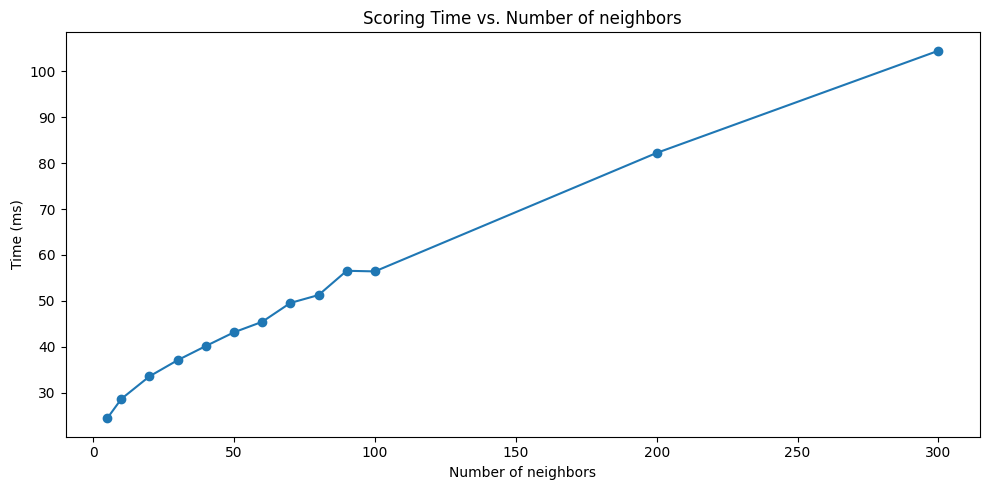

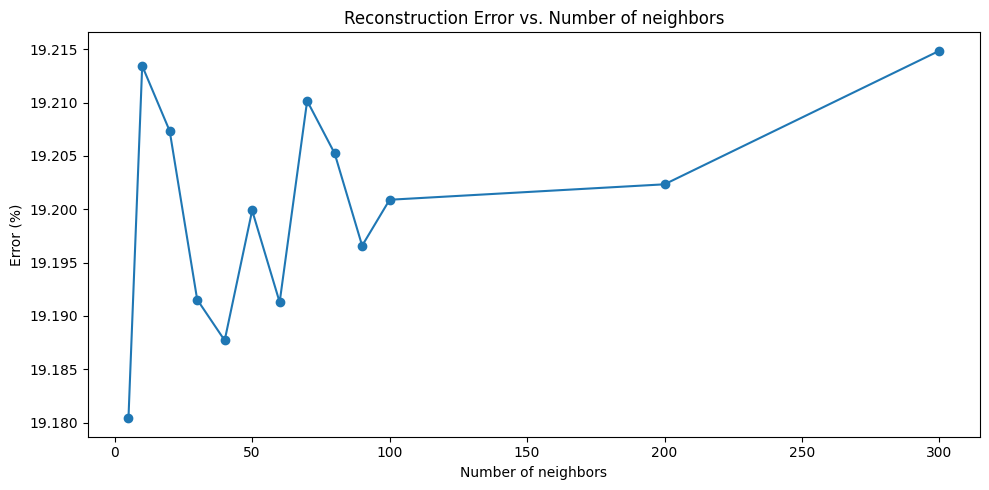

In [6]:
nmf_tuner_neighbors = NMFHyperparameterTuning_Neighbors(data="cifar10")
# nmf_tuner_neighbors.evaluate_nmf()
nmf_tuner_neighbors.load_results()
nmf_tuner_neighbors.plot_results()

the length of the CIFARO-100 Training dataset :  50000
the length of the CIFAR-100 Test dataset :  10000
moving data to :  cuda:0
checkpoint_path :  ../../models/CIFAR-100/cifar100_resnet18_32x32_base_e100_lr0.1_default/s0/best.ckpt
Model pretrained weight have been successfully loaded !


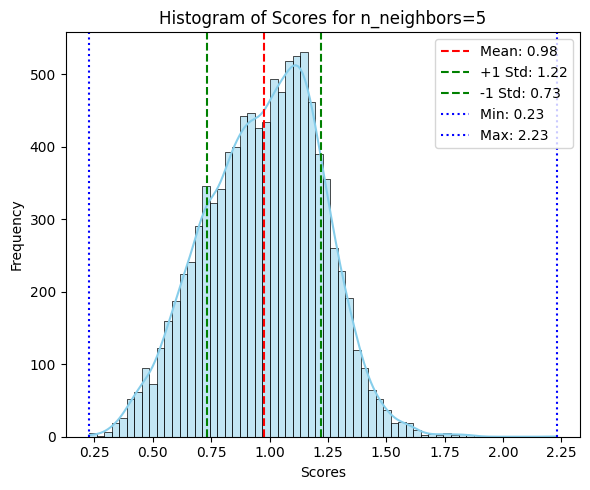

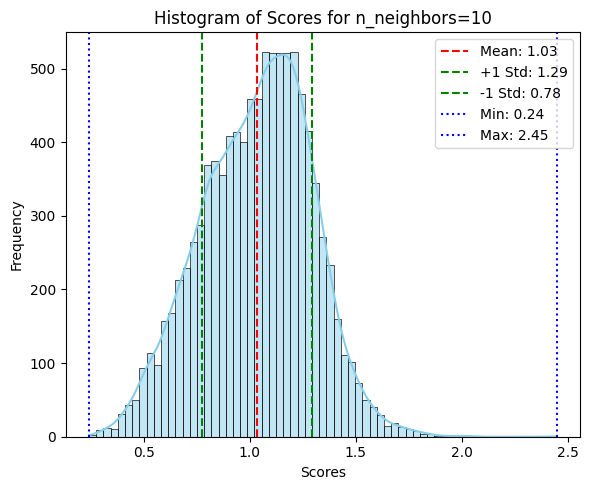

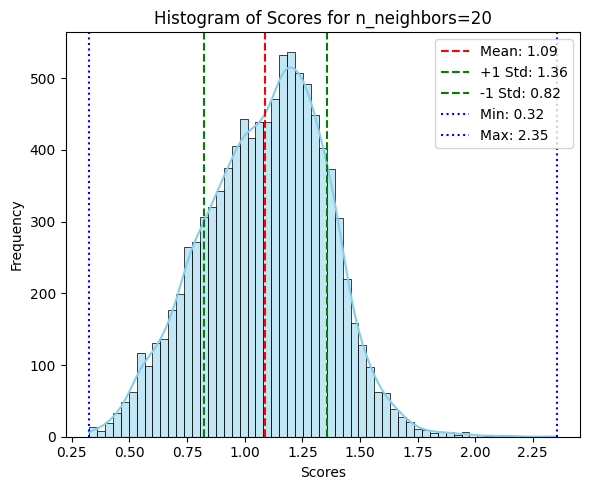

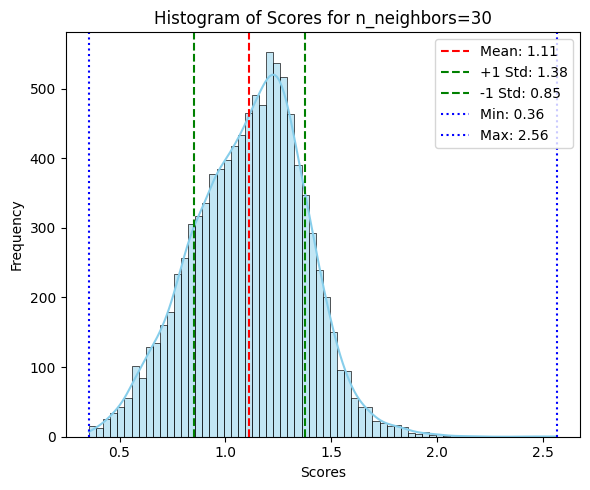

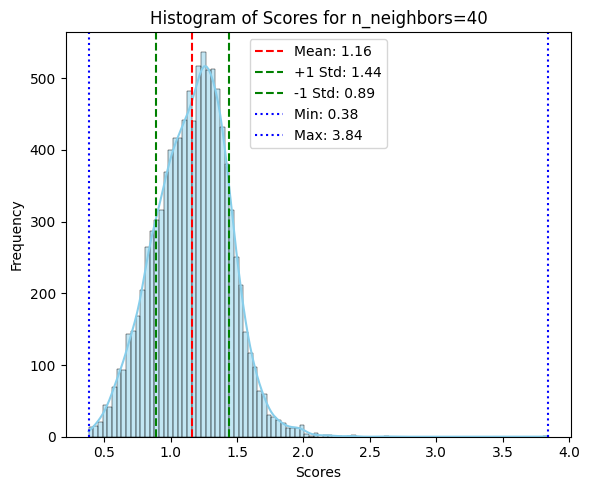

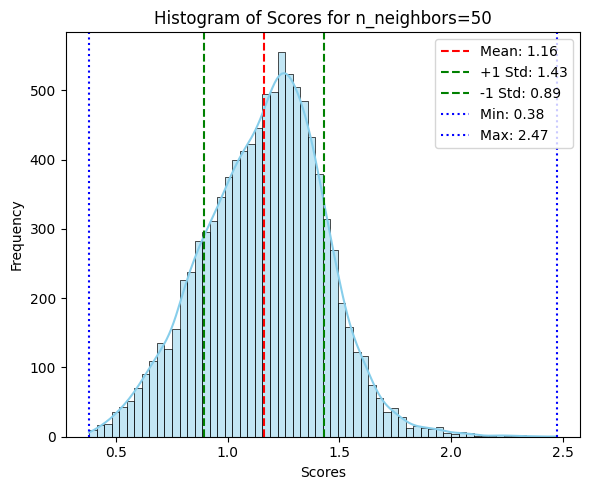

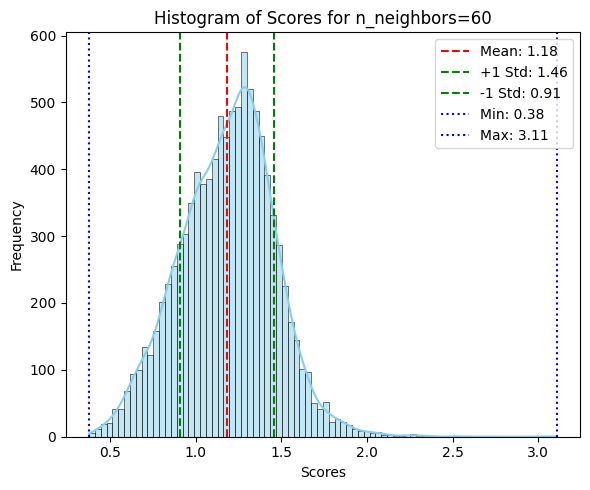

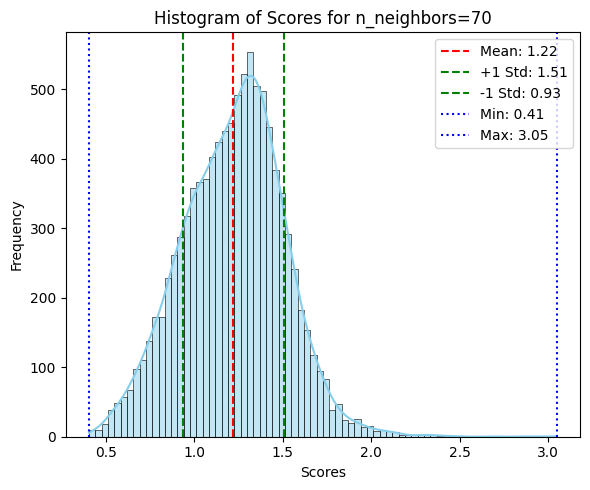

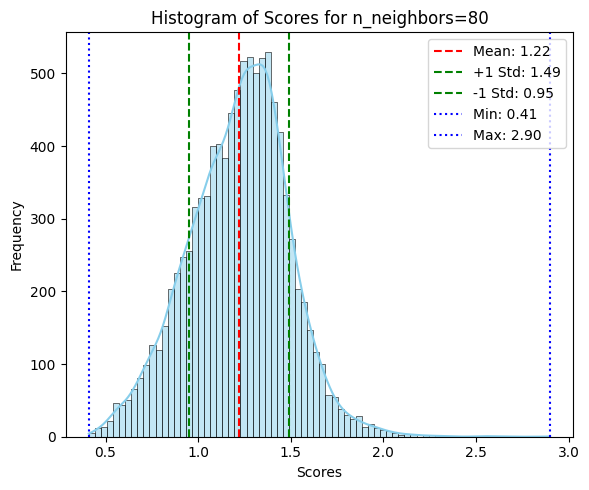

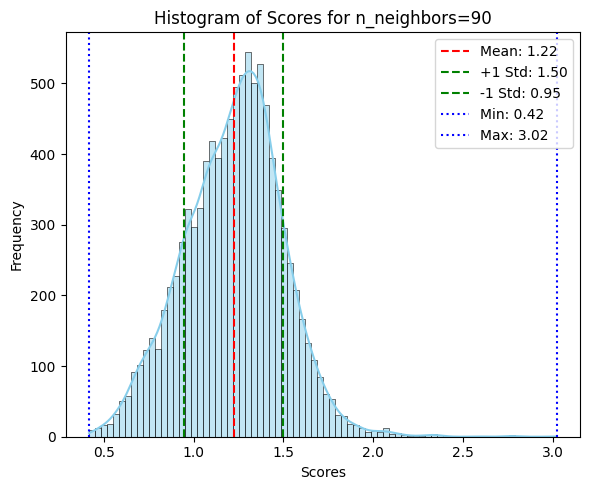

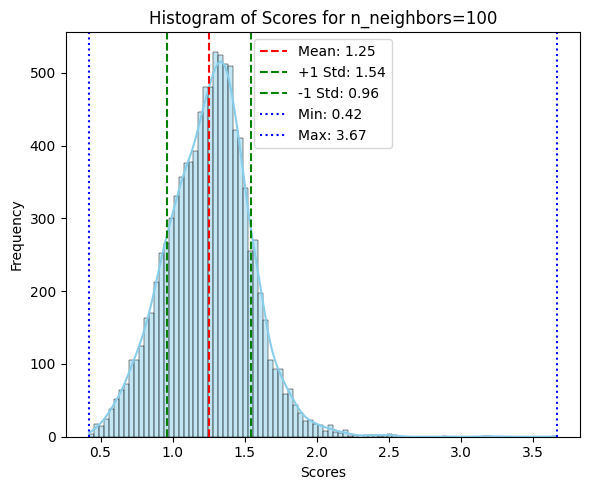

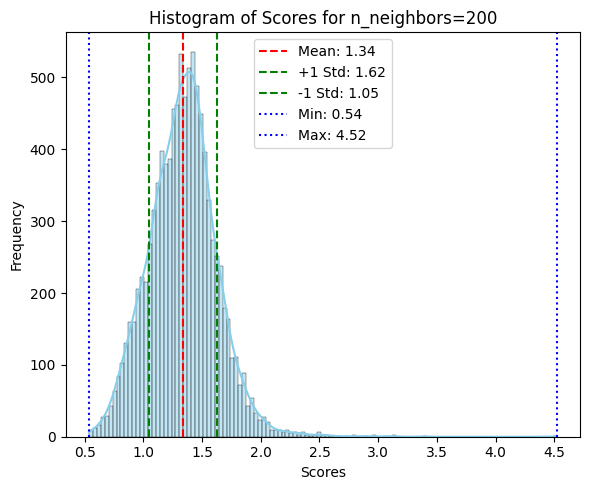

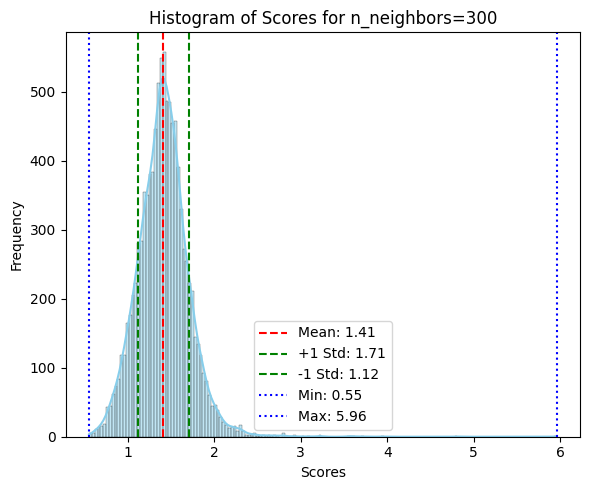

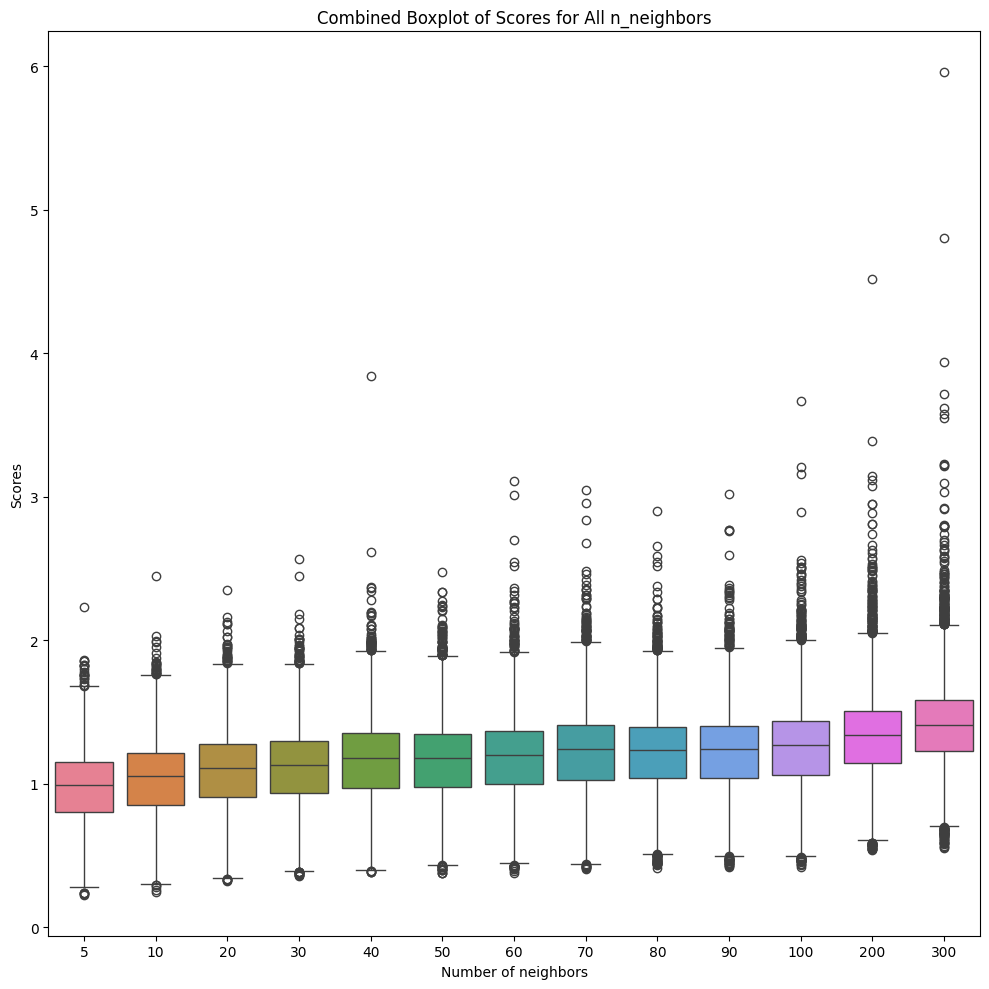

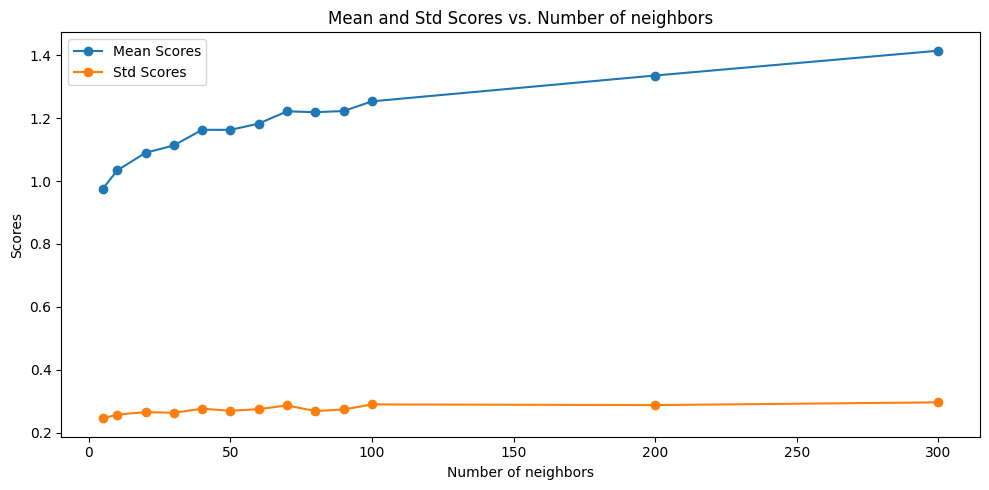

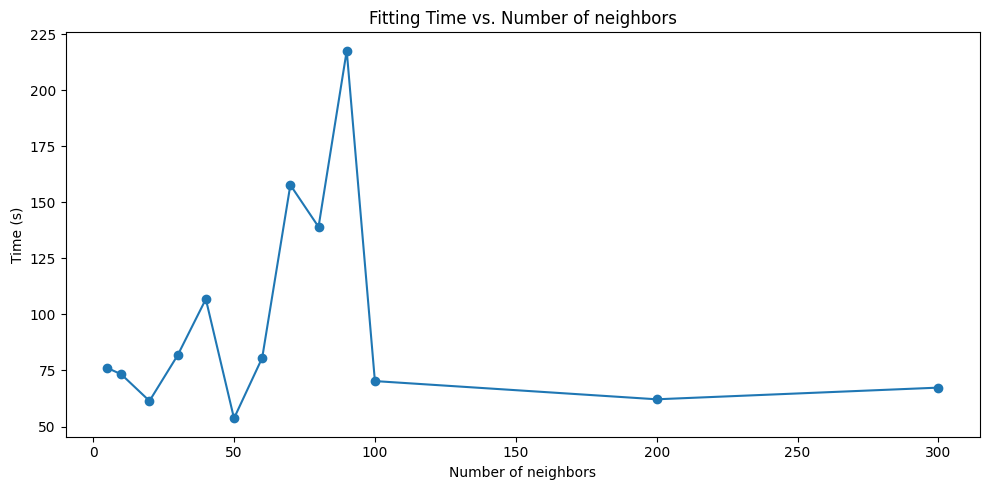

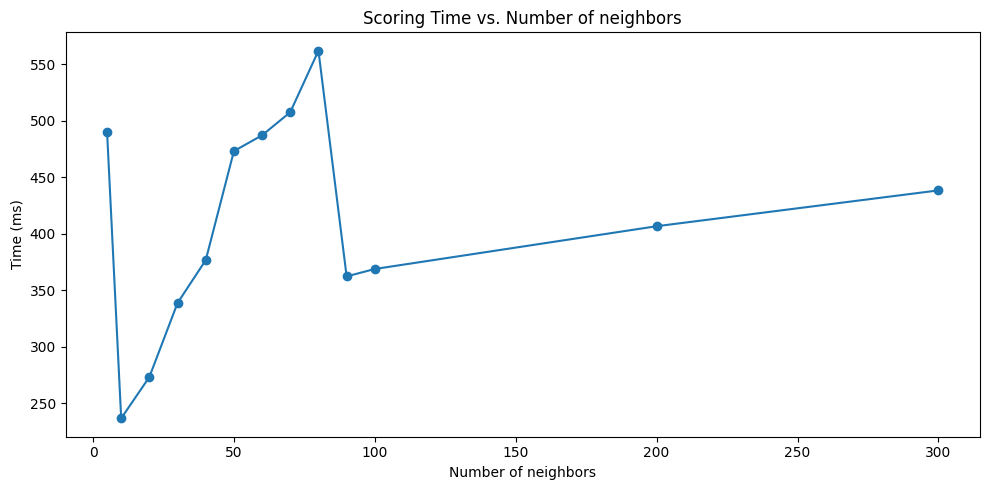

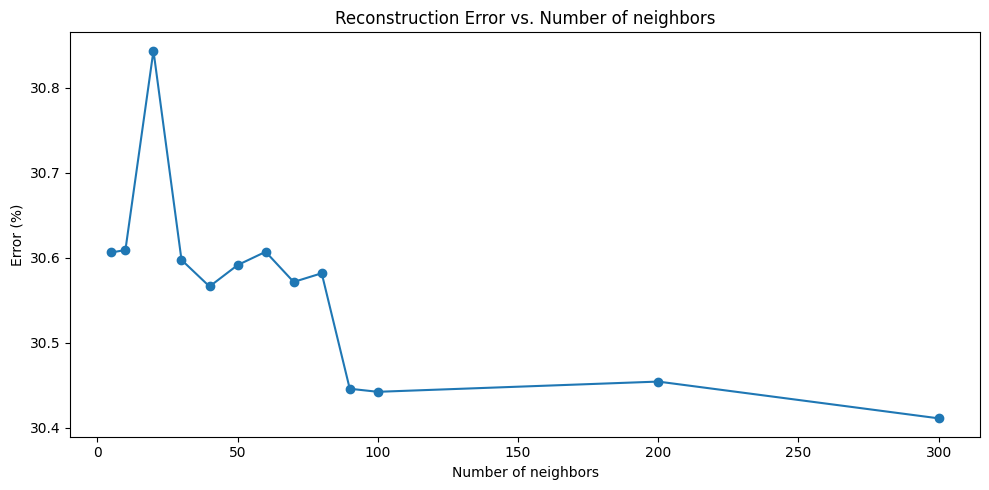

In [7]:
nmf_tuner_neighbors_100 = NMFHyperparameterTuning_Neighbors(data="cifar100")
# nmf_tuner_neighbors_100.evaluate_nmf()
nmf_tuner_neighbors_100.load_results()
nmf_tuner_neighbors_100.plot_results()

In [ ]:
# nmf_tuner_neighbors_1000 = NMFHyperparameterTuning_Neighbors(data="imagenet")
# nmf_tuner_neighbors_1000.evaluate_nmf()
# nmf_tuner_neighbors_1000.plot_results()